In [1]:
%pip install torch torchvision super-gradients numpy matplotlib pandas pillow albumentations scikit-learn imutils split-folders requests


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imutils import paths
import splitfolders
from super_gradients.training import models, training_hyperparams
from super_gradients.training import Trainer


In [3]:

# Configuration
class Config:
    DOWNLOAD_DIR = Path('input/Dataset')
    ROOT_DIR = Path('content')
    TRAIN_DIR = ROOT_DIR / 'train'
    TEST_DIR = ROOT_DIR / 'test'
    VAL_DIR = ROOT_DIR / 'val'
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224
    IMAGENET_MEAN = [0.50, 0.50, 0.50]
    IMAGENET_STD = [0.50, 0.50, 0.50]
    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 32
    MODEL_NAME = 'vit_base'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_vit_train_params'
    CHECKPOINT_DIR = 'checkpoints'
    NUM_CLASSES = len([d for d in DOWNLOAD_DIR.iterdir() if d.is_dir()])

config = Config()

# Split dataset
splitfolders.ratio(config.DOWNLOAD_DIR, output=config.ROOT_DIR, seed=42, ratio=(.8, .1, .1))


Copying files: 6245 files [00:07, 908.99 files/s]

In [4]:

# Data Augmentation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.INPUT_HEIGHT, config.INPUT_WIDTH)),
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.RandomVerticalFlip(p=0.75),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.INPUT_HEIGHT, config.INPUT_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
])

# DataLoader Creation
def create_dataloaders(batch_size: int, num_workers: int = 2):
    train_data = datasets.ImageFolder(config.TRAIN_DIR, transform=train_transforms)
    val_data = datasets.ImageFolder(config.VAL_DIR, transform=val_transforms)
    test_data = datasets.ImageFolder(config.TEST_DIR, transform=val_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader, train_data.classes

train_loader, val_loader, test_loader, class_names = create_dataloaders(config.BATCH_SIZE)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.best_metric = np.Inf if mode == 'min' else -np.Inf
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.mode == 'min':
            if current_metric < self.best_metric - self.delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
        elif self.mode == 'max':
            if current_metric > self.best_metric + self.delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.stop_training = True


Copying files: 6400 files [00:07, 828.01 files/s]


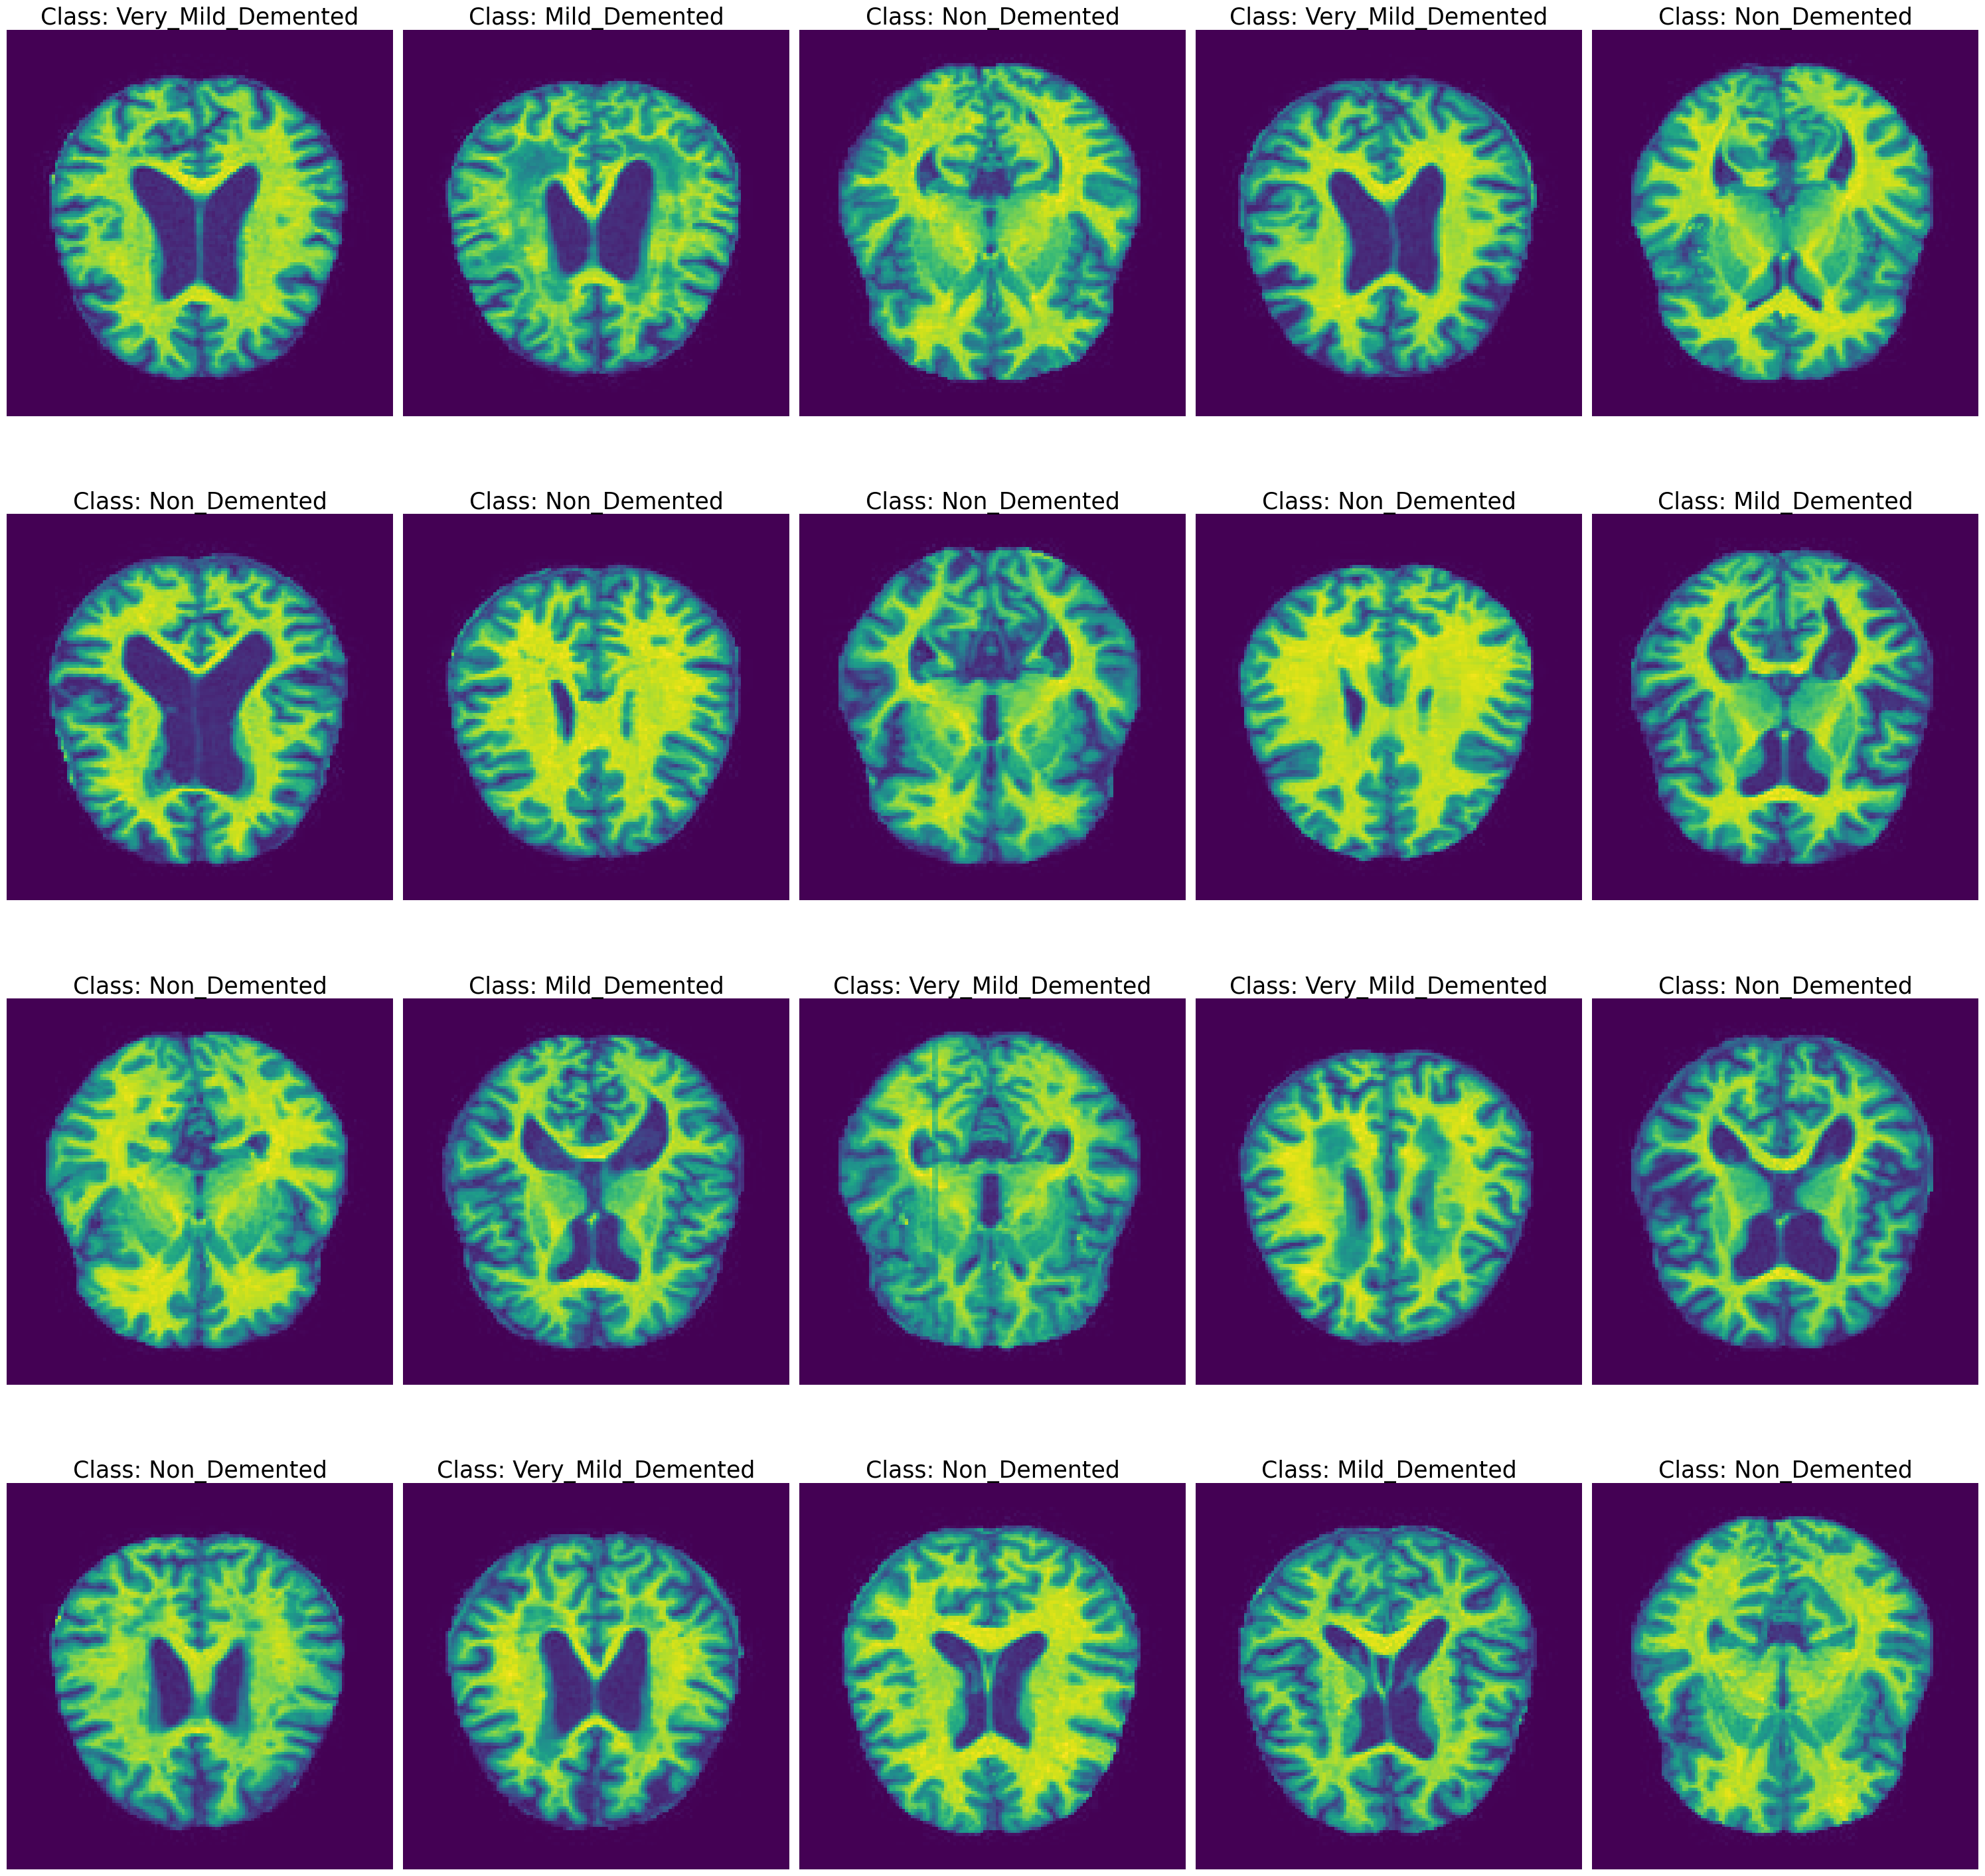

In [34]:
import math
from pathlib import Path, PurePath

train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/5))
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Class: {label}", fontsize=25)
        axs[i].axis('off')
    plt.show()

examine_images(train_image_path_sample)

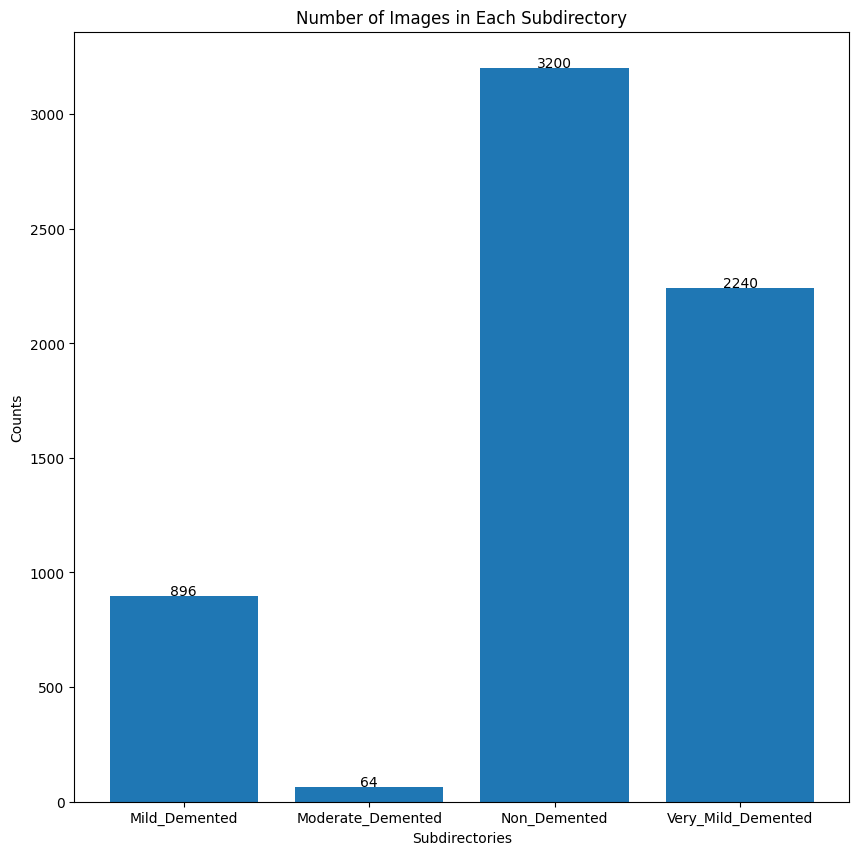

In [35]:
# Get a list of all subdirectories in the root directory
subdirs = [d for d in Path(config.DOWNLOAD_DIR).iterdir() if d.is_dir()]

image_count = {}

# Iterate through each subdirectory
for subdir in subdirs:
    subdir_images = list(sorted(paths.list_images(subdir)))
    image_count[subdir.name] = len(subdir_images)

# create a new figure with desired size
fig = plt.figure(figsize=(10, 10))

plt.bar(image_count.keys(), image_count.values())
# add the count numbers on top of the bars
for i, (subdir, count) in enumerate(image_count.items()):
    plt.text(i, count + 3, str(count), ha='center')

# set the title and labels for the plot
plt.title("Number of Images in Each Subdirectory")
plt.xlabel("Subdirectories")
plt.ylabel("Counts")

# show the plot
plt.show()

In [38]:
import pandas as pd
image_types = {'path': [], 'mode': []}
# loop over all image files in the root directory and its subdirectories
for file_path in paths.list_images(config.ROOT_DIR):
    # open the image using PIL and get its mode
    with Image.open(file_path) as img:
        image_types['path'].append(file_path)
        image_types['mode'].append(img.mode)

# create a dataframe from the data
image_types_df = pd.DataFrame(image_types)
image_types_df['mode'].value_counts()

def convert_l_to_rgb(image_path):
  img = Image.open(image_path)
  rgb_img = Image.merge('RGB', (img, img, img))
  rgb_img.save(image_path)

# Loop over all image paths in the dataframe and convert if needed
for index, row in image_types_df.iterrows():
    if row['mode'] == 'L':
        convert_l_to_rgb(row['path'])

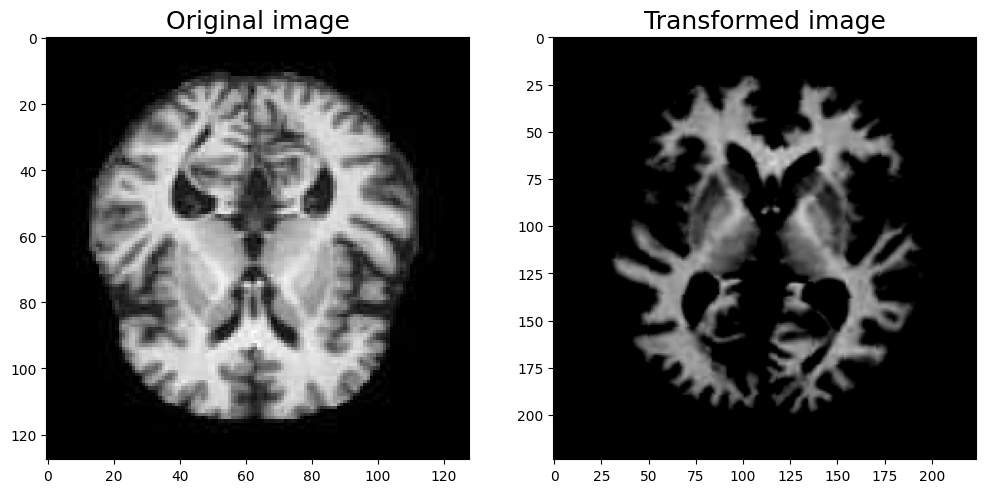

In [41]:
import torchvision
import albumentations as A

def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """
    # Apply the transform to the image
    if isinstance(transform, torchvision.transforms.Compose):
        # Apply PyTorch transform to image array
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
        # Apply Albumentations transform to image array
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    # Convert the image tensor to a numpy array and transpose the axes to (height, width, channels)
    img_array = transformed_image.numpy().transpose((1, 2, 0))

    # Clip the pixel values to the range [0, 1]
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18

    if original_image is None:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the transformed image in the first column.
        ax[0].imshow(image)
    else:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the original image in the first column.
        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)

        # Show the transformed image in the second column.
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

img = Image.open(random.choice(train_image_path_list))
img_array = apply_transform(img, train_transforms)
visualize_transform(img_array, original_image=img)

In [5]:

# Training Parameters
training_params = training_hyperparams.get(config.TRAINING_PARAMS)
training_params.update({
    "silent_mode": False,
    "optimizer": 'AdamW',
    "ema": True,
    "max_epochs": 50,  # Epochs 증가
    "initial_lr": 0.0001,
})

# Model Initialization
model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights='imagenet')

# Early Stopping Initialization
early_stopping = EarlyStopping(patience=5, delta=0.01, mode='min')

# Optimizer and Learning Rate Scheduler Initialization
optimizer = torch.optim.AdamW(model.parameters(), lr=training_params["initial_lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)


In [6]:

# Training Loop with Early Stopping
best_val_loss = np.Inf
for epoch in range(1, training_params["max_epochs"] + 1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}/{training_params['max_epochs']}, Training Loss: {running_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check Early Stopping Condition
    early_stopping(val_loss)
    scheduler.step(val_loss)  # 스케줄러 업데이트
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}. Best Validation Loss: {early_stopping.best_metric:.4f}")
        break

# Save the Model
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "dec4ckpt_best.pth"))


KeyboardInterrupt: 

In [7]:
# Save the Model
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "dec4ckpt_best.pth"))


In [8]:

# Predictions and Metrics
def get_predictions_and_metrics(model, test_loader):
    model.to(config.DEVICE)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

# Evaluate the Model
accuracy, precision, recall, f1 = get_predictions_and_metrics(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")



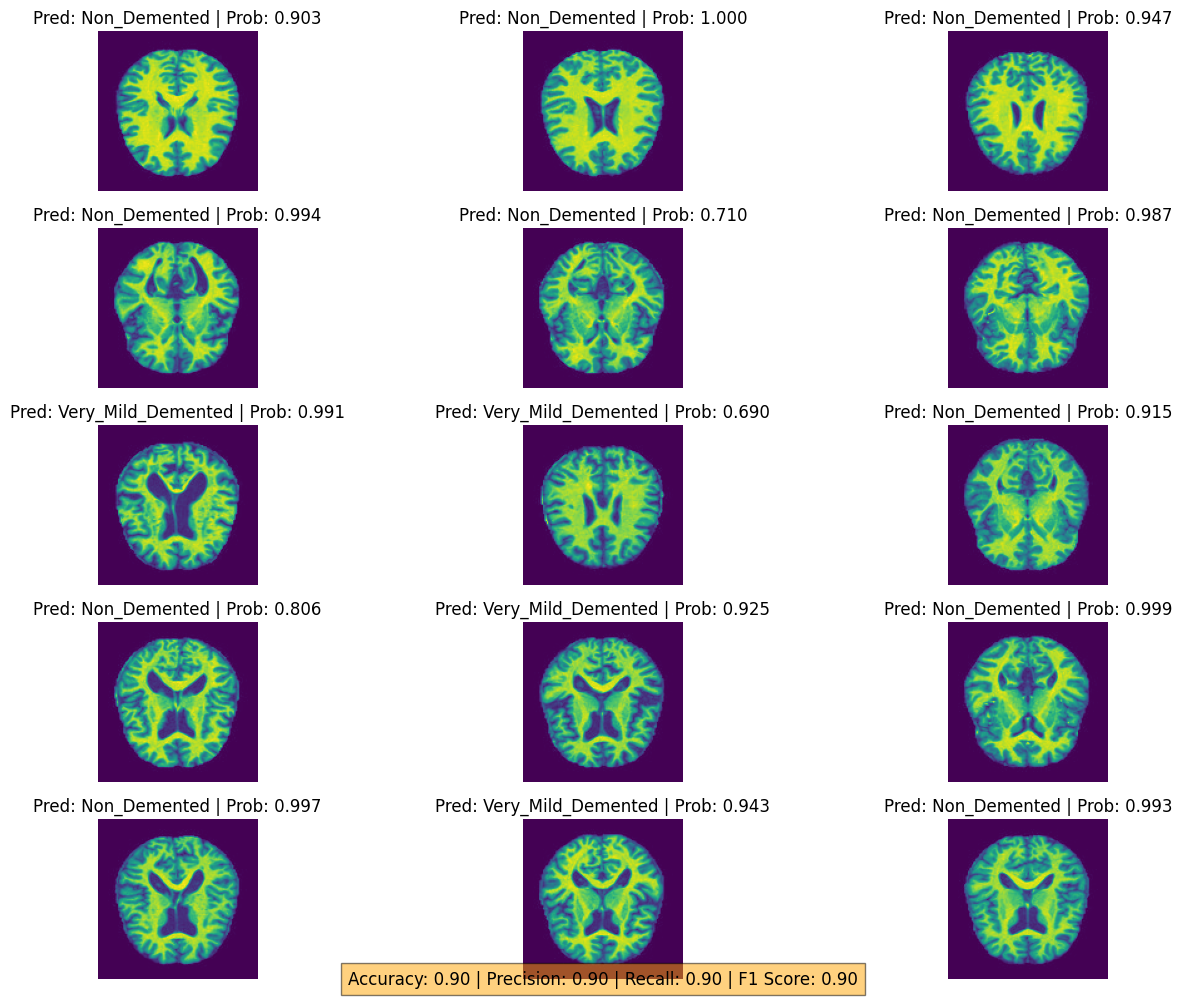

In [ ]:
#try1
from typing import List
# Predictions and Metrics Function
def get_predictions_and_metrics(model, test_loader):
    model.to(config.DEVICE)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1  # 4개 값 반환

# Updated function to predict and plot
def pred_and_plot_image(image_path: str, model, class_names: List[str]):
    img = Image.open(image_path)
    
    # Updated transform pipeline
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((config.INPUT_HEIGHT, config.INPUT_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
    ])
    
    model.to(config.DEVICE)
    model.eval()
    
    with torch.inference_mode():
        transformed_image = transform(img).unsqueeze(0).to(config.DEVICE)
        outputs = torch.softmax(model(transformed_image), dim=1)
        pred_label = torch.argmax(outputs, dim=1).item()
        pred_prob = outputs.max().item()
    
    return img, class_names[pred_label], pred_prob

# Updated function to plot random test images and calculate metrics
def plot_random_test_images(model, class_names, test_loader):
    num_images_to_plot = 15
    fig, ax = plt.subplots(5, 3, figsize=(15, 10))
    ax = ax.flatten()

    # Randomly sample test images
    image_paths = random.sample(list(paths.list_images(config.TEST_DIR)), num_images_to_plot)
    
    for i, image_path in enumerate(image_paths):
        img, pred_label, pred_prob = pred_and_plot_image(image_path, model, class_names)
        ax[i].imshow(img)
        ax[i].set_title(f"Pred: {pred_label} | Prob: {pred_prob:.3f}")
        ax[i].axis('off')

    # Calculate metrics
    accuracy, precision, recall, f1 = get_predictions_and_metrics(model, test_loader)  # 4개 값으로 수정

    # Display metrics
    plt.figtext(0.5, 0.01, f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()

# Plot random images with calculated metrics
plot_random_test_images(model, class_names, test_loader)


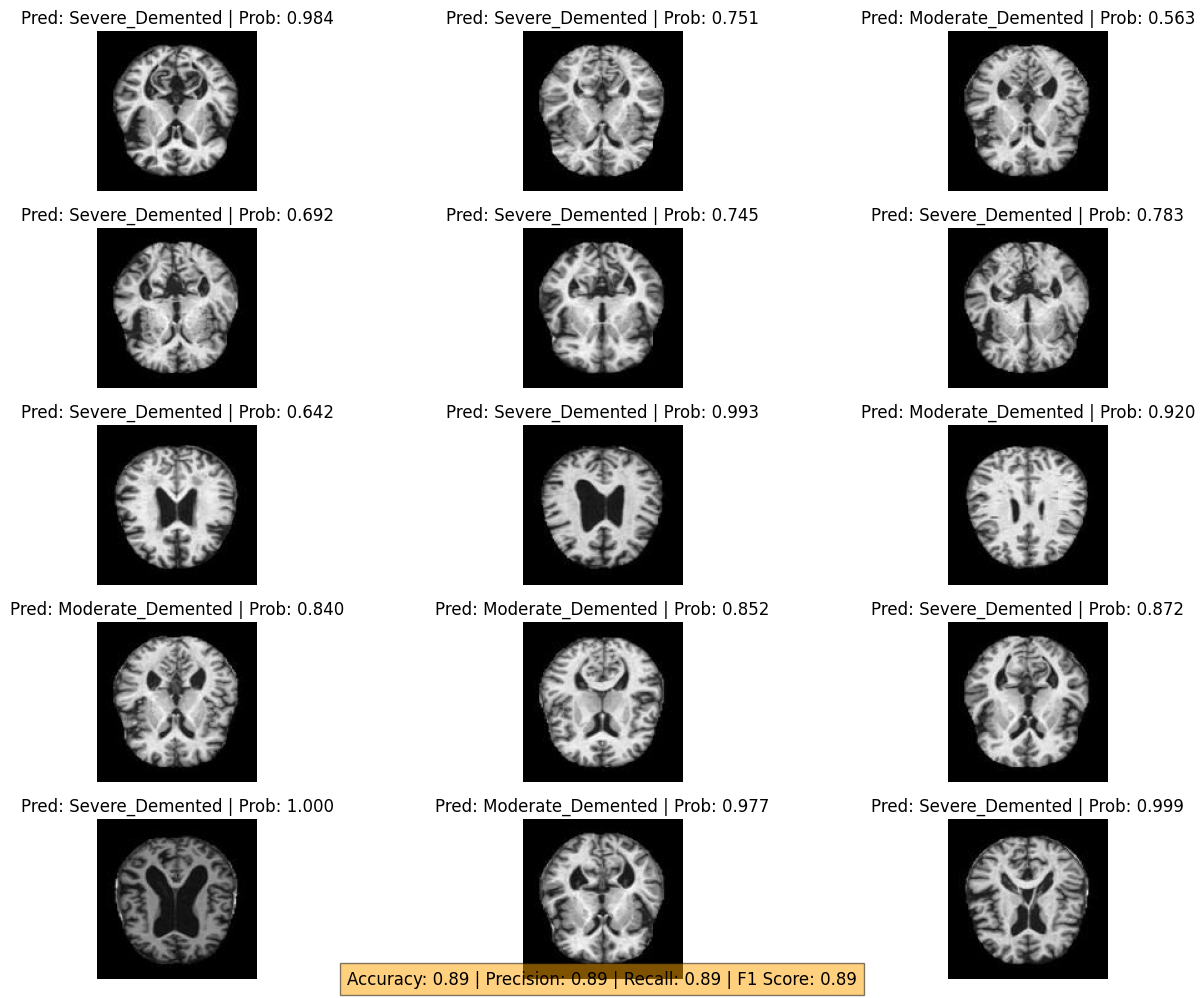

In [42]:
# Try2 Predictions and Metrics Function
def get_predictions_and_metrics(model, test_loader):
    model.to(config.DEVICE)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

# Updated function to predict and plot
def pred_and_plot_image(image_path: str, model, class_names: List[str]):
    img = Image.open(image_path)
    
    # Updated transform pipeline
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((config.INPUT_HEIGHT, config.INPUT_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
    ])
    
    model.to(config.DEVICE)
    model.eval()
    
    with torch.inference_mode():
        transformed_image = transform(img).unsqueeze(0).to(config.DEVICE)
        outputs = torch.softmax(model(transformed_image), dim=1)
        pred_label = torch.argmax(outputs, dim=1).item()
        pred_prob = outputs.max().item()
    
    return img, class_names[pred_label], pred_prob

# Updated function to plot random test images and calculate metrics
def plot_random_test_images(model, class_names, test_loader):
    num_images_to_plot = 15
    fig, ax = plt.subplots(5, 3, figsize=(15, 10))
    ax = ax.flatten()

    # Randomly sample test images
    image_paths = random.sample(list(paths.list_images(config.TEST_DIR)), num_images_to_plot)
    
    for i, image_path in enumerate(image_paths):
        img, pred_label, pred_prob = pred_and_plot_image(image_path, model, class_names)
        ax[i].imshow(img)
        ax[i].set_title(f"Pred: {pred_label} | Prob: {pred_prob:.3f}")
        ax[i].axis('off')

    # Calculate metrics
    accuracy, precision, recall, f1 = get_predictions_and_metrics(model, test_loader)

    # Display metrics
    plt.figtext(0.5, 0.01, f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()

# Plot random images with calculated metrics
plot_random_test_images(model, class_names, test_loader)


In [33]:
%pip install torch-summary

from torchsummary import summary

# Ensure the model is on the appropriate device
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Print a detailed summary of the model architecture
summary(model, input_size=(3, 224, 224))  # Adjust input size to match your model


Layer (type:depth-idx)                   Param #
├─PatchEmbed: 1-1                        --
|    └─Conv2d: 2-1                       590,592
|    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Transformer: 1-3                       --
|    └─ModuleList: 2-3                   --
|    |    └─TransformerBlock: 3-1        7,087,872
|    |    └─TransformerBlock: 3-2        7,087,872
|    |    └─TransformerBlock: 3-3        7,087,872
|    |    └─TransformerBlock: 3-4        7,087,872
|    |    └─TransformerBlock: 3-5        7,087,872
|    |    └─TransformerBlock: 3-6        7,087,872
|    |    └─TransformerBlock: 3-7        7,087,872
|    |    └─TransformerBlock: 3-8        7,087,872
|    |    └─TransformerBlock: 3-9        7,087,872
|    |    └─TransformerBlock: 3-10       7,087,872
|    |    └─TransformerBlock: 3-11       7,087,872
|    |    └─TransformerBlock: 3-12       7,087,872
├─LayerNorm: 1-4                         1,536
├─Linear: 1-5          


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


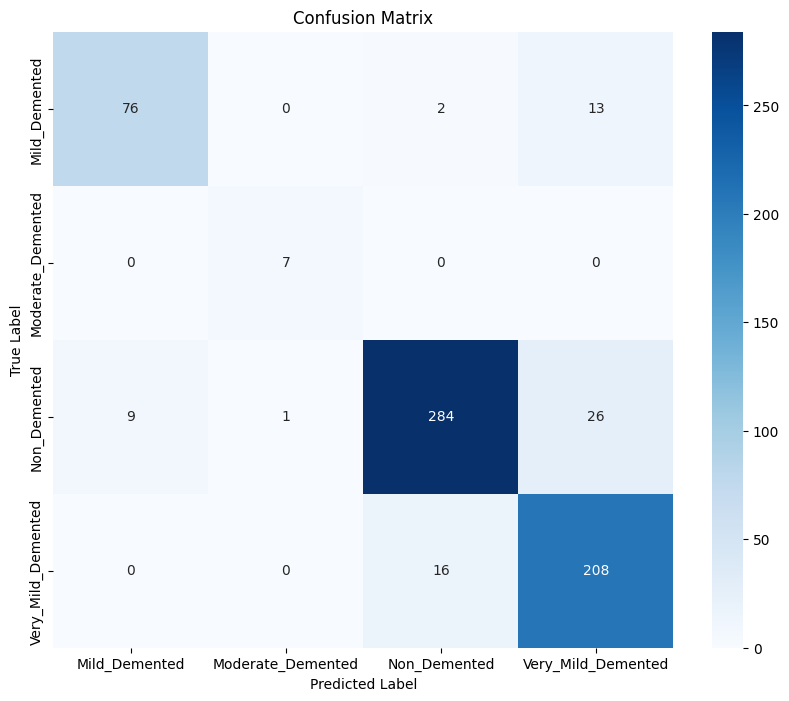

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader, class_names):
    model.to(config.DEVICE)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plotting the confusion matrix
plot_confusion_matrix(model, test_loader, class_names)